In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Verify implementation of divergence theorem using `sectionate` and `regionmask`

\begin{equation}
\iiint_{V} \nabla \cdot \mathbf{u} \; \text{d}V = \iint_{A} \mathbf{u} \cdot \mathbf{n} \; \text{d}A
\end{equation}

In [25]:
# Import packages
import numpy as np
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt

import geopandas as gpd
from shapely.geometry import Polygon
import regionmask
import sectionate as sec

# Don't display filter warnings
import warnings
warnings.filterwarnings("ignore")
# Set figure font size
plt.rcParams.update({'font.size':14})

### Load data (on `z` grid, but same approach works for all)

In [26]:
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
prefix = '19000101.ocean_'
grid = 'z'
suffix = 'thck'

filename = prefix+grid+'_'+suffix+'*.nc'
ds = xr.open_mfdataset(rootdir+filename).isel(time=0)
og = xr.open_mfdataset(rootdir+prefix+"static.nc")

g_z = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                     'Y': {'center': 'yh', 'right': 'yq'},
                     'Z': {'inner': 'z_l', 'outer': 'z_i'} })

rho0 = 1035.

#### Define an arbitrary close sub-region of the domain defined by an irregular polygon

In [27]:
xx = np.array([13, 18, 20.5, 21.5, 18.25, 17])
yy = np.array([54., 53.5, 54.5, 57.1, 56.75, 59])

#### Find the consecutive vorticity grid points that closest follows the polygon

In [28]:
i, j, x, y = sec.create_section_composite(
    og['geolon_c'],
    og['geolat_c'],
    np.append(xx, xx[0]),
    np.append(yy, yy[0]),
    closed=True
)

#### Use `shapely`, `geopandas`, and `regionmask` to find the tracer grid cells that fall within the closed section

In [29]:
polygon_geom = Polygon(zip(x, y))
crs = 'epsg:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

region_mask = ~np.isnan(regionmask.mask_geopandas(polygon, og['geolon'], lat=og['geolat'], wrap_lon='360'))

#### Find the indices, orientations, and coordinates of the convergent transports across the section

In [30]:
symmetric = og['geolon'].shape==og['geolon_c'].shape
uvpoints = sec.transports_C.MOM6_UVpoints_from_section(i, j, symmetric=symmetric)

#### For a symmetric grid, we create a non-symmetric (lon, lat) grid for better plotting

In [31]:
geolon_c, geolat_c = np.zeros((og.yh.size+1, og.xh.size+1)), np.zeros(((og.yh.size+1, og.xh.size+1)))
geolon_c[1:,1:] = og.geolon_c.data
geolon_c[0, :] = geolon_c[1, :]
geolon_c[:, 0] = geolon_c[:, 1] - (geolon_c[:, 2] - geolon_c[:, 1]) 

geolat_c[1:,1:] = og.geolat_c.data
geolat_c[:, 0] = geolat_c[:, 1]
geolat_c[0, :] = geolat_c[1, :] - (geolat_c[2, :] - geolat_c[1, :])

#### We find the coordinates of the (U,V) points along the section (just for plotting)

In [32]:
uv_lons, uv_lats = sec.transports_C.MOM6_UVcoords_from_points_uv(
    og['geolon_u'],
    og['geolat_u'],
    og['geolon_v'],
    og['geolat_v'],
    uvpoints,
    symmetric=symmetric
)

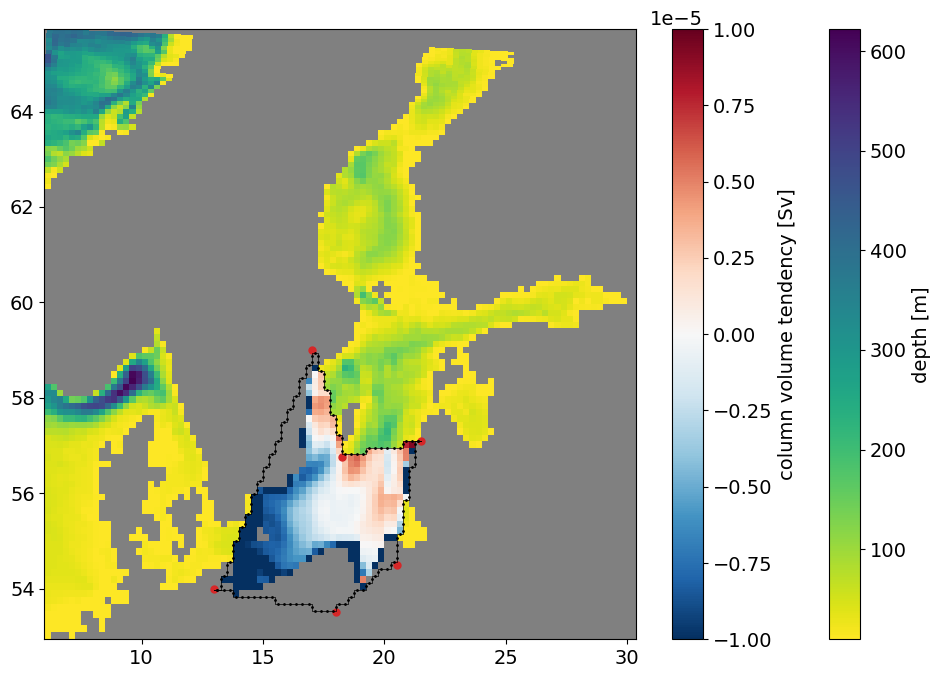

In [38]:
import matplotlib

dhdt = (ds['dynamics_h_tendency']*og['areacello']*1e-6).sum('z_l')
dhdt = dhdt.where(dhdt!=0.)

plt.figure(figsize=(10, 7))
plt.subplot(facecolor="grey")
pc = plt.pcolormesh(
    geolon_c, geolat_c,
    dhdt.where(region_mask),
    alpha=1.0, cmap="RdBu_r", vmin=-1e-5, vmax=1e-5
)
pc_dep = plt.pcolormesh(geolon_c, geolat_c, og.depth_ocean.where(~region_mask), cmap="viridis_r")
plt.plot(xx, yy, "C3o", markersize=5)
plt.plot(x, y, "k-", linewidth=0.5)
plt.plot(uv_lons, uv_lats, "k.", markersize=2.)
plt.colorbar(pc_dep, label="depth [m]")
plt.colorbar(pc, label="column volume tendency [Sv]")
plt.tight_layout()

In [34]:
Tconv = sec.MOM6_convergent_transport(ds, i, j, layer="z_l", interface="z_i", symmetric=symmetric)
Ψ = -Tconv['uvnormal'].cumsum("sect").cumsum('z_l').compute() # kg/s

In [35]:
Ψ0 = Ψ.isel(sect=-1, z_l=-1).values/rho0*1e-6

In [36]:
Ψ0_tend = -dhdt.where(region_mask).sum(['xh', 'yh']).values

In [37]:
np.isclose(Ψ0, Ψ0_tend, rtol=1.e-6)

True